##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Transfer learning with TensorFlow Hub

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning_with_hub.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning_with_hub.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/transfer_learning_with_hub.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

[TensorFlow Hub](https://tfhub.dev/) is a repository of pre-trained TensorFlow models.

This tutorial demonstrates how to:

1. Use models from TensorFlow Hub with `tf.keras`.
1. Use an image classification model from TensorFlow Hub.
1. Do simple transfer learning to fine-tune a model for your own image classes.

## Setup

In [2]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import datetime

%load_ext tensorboard

2023-10-27 06:09:42.068839: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-27 06:09:42.068886: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-27 06:09:42.070427: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## An ImageNet classifier

You'll start by using a classifier model pre-trained on the [ImageNet](https://en.wikipedia.org/wiki/ImageNet) benchmark dataset—no initial training required!

### Download the classifier

Select a <a href="https://arxiv.org/abs/1801.04381" class="external">MobileNetV2</a> pre-trained model [from TensorFlow Hub](https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2) and wrap it as a Keras layer with [`hub.KerasLayer`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer). Any <a href="https://tfhub.dev/s?q=tf2&module-type=image-classification/" class="external">compatible image classifier model</a> from TensorFlow Hub will work here, including the examples provided in the drop-down below.

In [3]:
mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

classifier_model = mobilenet_v2 #@param ["mobilenet_v2", "inception_v3"] {type:"raw"}

In [4]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

### Run it on a single image

Download a single image to try the model on:

 8192/61306 [===>..........................] - ETA: 0s

61306/61306 [==============================] - 0s 0us/step


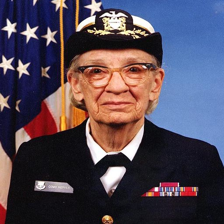

In [5]:
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [6]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

Add a batch dimension (with `np.newaxis`) and pass the image to the model:

In [7]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 2s 2s/step


(1, 1001)

The result is a 1001-element vector of logits, rating the probability of each class for the image.

The top class ID can be found with `tf.math.argmax`:

In [8]:
predicted_class = tf.math.argmax(result[0], axis=-1)
predicted_class

<tf.Tensor: shape=(), dtype=int64, numpy=653>

### Decode the predictions

Take the `predicted_class` ID (such as `653`) and fetch the ImageNet dataset labels to decode the predictions:

In [9]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

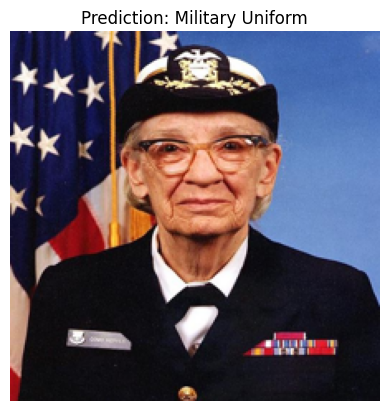

In [10]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

## Simple transfer learning

But what if you want to create a custom classifier using your own dataset that has classes that aren't included in the original ImageNet dataset (that the pre-trained model was trained on)?

To do that, you can:

1. Select a pre-trained model from TensorFlow Hub; and
2. Retrain the top (last) layer to recognize the classes from your custom dataset.

### Dataset

In this example, you will use the TensorFlow flowers dataset:

In [11]:
import pathlib

data_file = tf.keras.utils.get_file(
  'flower_photos.tgz',
  'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
  cache_dir='.',
   extract=True)

data_root = pathlib.Path(data_file).with_suffix('')

     8192/228813984 [..............................] - ETA: 0s

  8396800/228813984 [>.............................] - ETA: 2s

 22167552/228813984 [=>............................] - ETA: 1s

 32858112/228813984 [===>..........................] - ETA: 1s

 44924928/228813984 [====>.........................] - ETA: 1s

 55517184/228813984 [======>.......................] - ETA: 0s

 67551232/228813984 [=======>......................] - ETA: 0s

 82681856/228813984 [=========>....................] - ETA: 0s

 97574912/228813984 [===========>..................] - ETA: 0s

110452736/228813984 [=============>................] - ETA: 0s

124805120/228813984 [===============>..............] - ETA: 0s

138199040/228813984 [=================>............] - ETA: 0s

150601728/228813984 [==================>...........] - ETA: 0s

160628736/228813984 [====================>.........] - ETA: 0s

173481984/228813984 [=====================>........] - ETA: 0s

182640640/228813984 [======================>.......] - ETA: 0s

195420160/228813984 [========================>.....] - ETA: 0s

208199680/228813984 [==========================>...] - ETA: 0s

223379456/228813984 [============================>.] - ETA: 0s

228813984/228813984 [==============================] - 1s 0us/step


First, load this data into the model using the image data off disk with `tf.keras.utils.image_dataset_from_directory`, which will generate a `tf.data.Dataset`:

In [12]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 3670 files belonging to 5 classes.


Using 2936 files for training.


Found 3670 files belonging to 5 classes.


Using 734 files for validation.


The flowers dataset has five classes:

In [13]:
class_names = np.array(train_ds.class_names)
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


Second, because TensorFlow Hub's convention for image models is to expect float inputs in the `[0, 1]` range, use the `tf.keras.layers.Rescaling` preprocessing layer to achieve this.

Note: You could also include the `tf.keras.layers.Rescaling` layer inside the model. Refer to the [Working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) guide for a discussion of the tradeoffs.

In [14]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

Third, finish the input pipeline by using buffered prefetching with `Dataset.prefetch`, so you can yield the data from disk without I/O blocking issues.

These are some of the most important `tf.data` methods you should use when loading data. Interested readers can learn more about them, as well as how to cache data to disk and other techniques, in the [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance#prefetching) guide.

In [15]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


2023-10-27 06:09:55.781735: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### Run the classifier on a batch of images

Now, run the classifier on an image batch:

In [17]:
result_batch = classifier.predict(train_ds)

 1/92 [..............................] - ETA: 2:49

 4/92 [>.............................] - ETA: 2s  

 6/92 [>.............................] - ETA: 2s

 8/92 [=>............................] - ETA: 2s

10/92 [==>...........................] - ETA: 2s

12/92 [==>...........................] - ETA: 2s

14/92 [===>..........................] - ETA: 2s

16/92 [====>.........................] - ETA: 2s

18/92 [====>.........................] - ETA: 2s

20/92 [=====>........................] - ETA: 2s

22/92 [======>.......................] - ETA: 1s

24/92 [======>.......................] - ETA: 1s

26/92 [=======>......................] - ETA: 1s

28/92 [========>.....................] - ETA: 1s

30/92 [========>.....................] - ETA: 1s

32/92 [=========>....................] - ETA: 1s

34/92 [==========>...................] - ETA: 1s

36/92 [==========>...................] - ETA: 1s

38/92 [===========>..................] - ETA: 1s

40/92 [============>.................] - ETA: 1s

42/92 [============>.................] - ETA: 1s

44/92 [=============>................] - ETA: 1s

46/92 [==============>...............] - ETA: 1s

48/92 [==============>...............] - ETA: 1s

50/92 [===============>..............] - ETA: 1s

52/92 [===============>..............] - ETA: 1s

54/92 [================>.............] - ETA: 1s

56/92 [=================>............] - ETA: 1s

58/92 [=================>............] - ETA: 0s

60/92 [==================>...........] - ETA: 0s

62/92 [===================>..........] - ETA: 0s

64/92 [===================>..........] - ETA: 0s

66/92 [====================>.........] - ETA: 0s

68/92 [=====================>........] - ETA: 0s

70/92 [=====================>........] - ETA: 0s

72/92 [======================>.......] - ETA: 0s

74/92 [=======================>......] - ETA: 0s

76/92 [=======================>......] - ETA: 0s

78/92 [========================>.....] - ETA: 0s

80/92 [=========================>....] - ETA: 0s

82/92 [=========================>....] - ETA: 0s

84/92 [==========================>...] - ETA: 0s

86/92 [===========================>..] - ETA: 0s

88/92 [===========================>..] - ETA: 0s

90/92 [============================>.] - ETA: 0s

92/92 [==============================] - ETA: 0s

92/92 [==============================] - 6s 41ms/step


In [18]:
predicted_class_names = imagenet_labels[tf.math.argmax(result_batch, axis=-1)]
predicted_class_names

array(['daisy', 'coral fungus', 'rapeseed', ..., 'daisy', 'daisy',
       'birdhouse'], dtype='<U30')

Check how these predictions line up with the images:

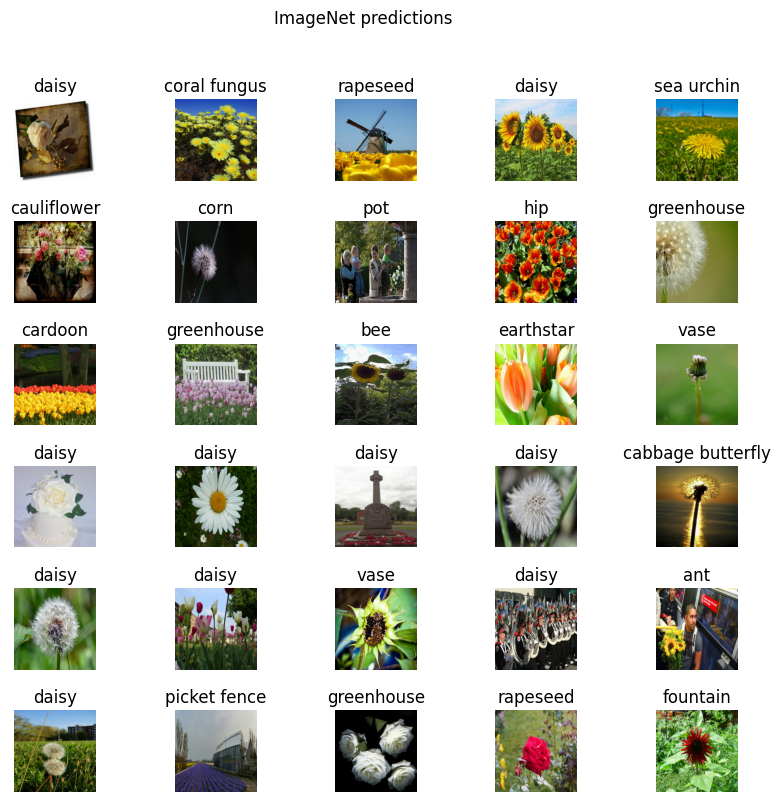

In [19]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

Note: all images are licensed CC-BY, creators are listed in the LICENSE.txt file.

The results are far from perfect, but reasonable considering that these are not the classes the model was trained for (except for "daisy").

### Download the headless model

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily perform transfer learning.

Select a <a href="https://arxiv.org/abs/1801.04381" class="external">MobileNetV2</a> pre-trained model <a href="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" class="external">from TensorFlow Hub</a>. Any <a href="https://tfhub.dev/s?module-type=image-feature-vector&q=tf2" class="external">compatible image feature vector model</a> from TensorFlow Hub will work here, including the examples from the drop-down menu.

In [20]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = mobilenet_v2 #@param ["mobilenet_v2", "inception_v3"] {type:"raw"}

Create the feature extractor by wrapping the pre-trained model as a Keras layer with [`hub.KerasLayer`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer). Use the `trainable=False` argument to freeze the variables, so that the training only modifies the new classifier layer:

In [21]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

The feature extractor returns a 1280-long vector for each image (the image batch size remains at 32 in this example):

In [22]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


### Attach a classification head

To complete the model, wrap the feature extractor layer in a `tf.keras.Sequential` model and add a fully-connected layer for classification:

In [23]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_1"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   


 dense (Dense)               (None, 5)                 6405      


Total params: 2264389 (8.64 MB)


Trainable params: 6405 (25.02 KB)


Non-trainable params: 2257984 (8.61 MB)


_________________________________________________________________


In [24]:
predictions = model(image_batch)

In [25]:
predictions.shape

TensorShape([32, 5])

### Train the model

Use `Model.compile` to configure the training process and add a `tf.keras.callbacks.TensorBoard` callback to create and store logs:

In [26]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

Now use the `Model.fit` method to train the model.

To keep this example short, you'll be training for just 10 epochs. To visualize the training progress in TensorBoard later, create and store logs an a [TensorBoard callback](https://www.tensorflow.org/tensorboard/get_started#using_tensorboard_with_keras_modelfit).

In [27]:
NUM_EPOCHS = 10

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

Epoch 1/10


I0000 00:00:1698387008.305202  503347 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 1/92 [..............................] - ETA: 5:33 - loss: 1.7696 - acc: 0.2812

 3/92 [..............................] - ETA: 4s - loss: 1.6058 - acc: 0.3229  

 5/92 [>.............................] - ETA: 4s - loss: 1.6360 - acc: 0.3250

 7/92 [=>............................] - ETA: 3s - loss: 1.5757 - acc: 0.3482

 9/92 [=>............................] - ETA: 3s - loss: 1.5221 - acc: 0.3542

11/92 [==>...........................] - ETA: 3s - loss: 1.4403 - acc: 0.3864

13/92 [===>..........................] - ETA: 3s - loss: 1.3932 - acc: 0.4183

15/92 [===>..........................] - ETA: 3s - loss: 1.3351 - acc: 0.4437

17/92 [====>.........................] - ETA: 3s - loss: 1.3074 - acc: 0.4596

19/92 [=====>........................] - ETA: 2s - loss: 1.2666 - acc: 0.4836

21/92 [=====>........................] - ETA: 2s - loss: 1.2355 - acc: 0.4970

23/92 [======>.......................] - ETA: 2s - loss: 1.1976 - acc: 0.5217

25/92 [=======>......................] - ETA: 2s - loss: 1.1673 - acc: 0.5387

27/92 [=======>......................] - ETA: 2s - loss: 1.1484 - acc: 0.5475

29/92 [========>.....................] - ETA: 2s - loss: 1.1134 - acc: 0.5614

31/92 [=========>....................] - ETA: 2s - loss: 1.0860 - acc: 0.5716

33/92 [=========>....................] - ETA: 2s - loss: 1.0647 - acc: 0.5852

35/92 [==========>...................] - ETA: 2s - loss: 1.0440 - acc: 0.5955

37/92 [===========>..................] - ETA: 2s - loss: 1.0162 - acc: 0.6098

39/92 [===========>..................] - ETA: 2s - loss: 0.9910 - acc: 0.6210

41/92 [============>.................] - ETA: 1s - loss: 0.9707 - acc: 0.6311

43/92 [=============>................] - ETA: 1s - loss: 0.9570 - acc: 0.6381

45/92 [=============>................] - ETA: 1s - loss: 0.9453 - acc: 0.6396

47/92 [==============>...............] - ETA: 1s - loss: 0.9324 - acc: 0.6449

49/92 [==============>...............] - ETA: 1s - loss: 0.9165 - acc: 0.6511

51/92 [===============>..............] - ETA: 1s - loss: 0.8985 - acc: 0.6593

53/92 [================>.............] - ETA: 1s - loss: 0.8828 - acc: 0.6669

55/92 [================>.............] - ETA: 1s - loss: 0.8724 - acc: 0.6705

57/92 [=================>............] - ETA: 1s - loss: 0.8589 - acc: 0.6754

59/92 [==================>...........] - ETA: 1s - loss: 0.8481 - acc: 0.6790

61/92 [==================>...........] - ETA: 1s - loss: 0.8349 - acc: 0.6849

63/92 [===================>..........] - ETA: 1s - loss: 0.8220 - acc: 0.6905

65/92 [====================>.........] - ETA: 1s - loss: 0.8189 - acc: 0.6923

67/92 [====================>.........] - ETA: 0s - loss: 0.8162 - acc: 0.6954

69/92 [=====================>........] - ETA: 0s - loss: 0.8050 - acc: 0.7006

71/92 [======================>.......] - ETA: 0s - loss: 0.7975 - acc: 0.7055

73/92 [======================>.......] - ETA: 0s - loss: 0.7854 - acc: 0.7115

75/92 [=======================>......] - ETA: 0s - loss: 0.7747 - acc: 0.7163

77/92 [========================>.....] - ETA: 0s - loss: 0.7679 - acc: 0.7183

79/92 [========================>.....] - ETA: 0s - loss: 0.7573 - acc: 0.7227

81/92 [=========================>....] - ETA: 0s - loss: 0.7513 - acc: 0.7249

83/92 [==========================>...] - ETA: 0s - loss: 0.7421 - acc: 0.7289

85/92 [==========================>...] - ETA: 0s - loss: 0.7371 - acc: 0.7316

87/92 [===========================>..] - ETA: 0s - loss: 0.7352 - acc: 0.7324

89/92 [============================>.] - ETA: 0s - loss: 0.7314 - acc: 0.7335

91/92 [============================>.] - ETA: 0s - loss: 0.7241 - acc: 0.7366

92/92 [==============================] - 11s 83ms/step - loss: 0.7225 - acc: 0.7367 - val_loss: 0.4207 - val_acc: 0.8678


Epoch 2/10


 1/92 [..............................] - ETA: 3s - loss: 0.3616 - acc: 0.8750

 3/92 [..............................] - ETA: 3s - loss: 0.4102 - acc: 0.8646

 5/92 [>.............................] - ETA: 3s - loss: 0.4399 - acc: 0.8687

 7/92 [=>............................] - ETA: 3s - loss: 0.4505 - acc: 0.8482

 9/92 [=>............................] - ETA: 3s - loss: 0.4169 - acc: 0.8576

11/92 [==>...........................] - ETA: 2s - loss: 0.4151 - acc: 0.8608

13/92 [===>..........................] - ETA: 2s - loss: 0.4223 - acc: 0.8582

15/92 [===>..........................] - ETA: 2s - loss: 0.4241 - acc: 0.8604

17/92 [====>.........................] - ETA: 2s - loss: 0.4453 - acc: 0.8511

19/92 [=====>........................] - ETA: 2s - loss: 0.4330 - acc: 0.8553

21/92 [=====>........................] - ETA: 2s - loss: 0.4310 - acc: 0.8527

23/92 [======>.......................] - ETA: 2s - loss: 0.4251 - acc: 0.8587

25/92 [=======>......................] - ETA: 2s - loss: 0.4170 - acc: 0.8637

27/92 [=======>......................] - ETA: 2s - loss: 0.4211 - acc: 0.8600

29/92 [========>.....................] - ETA: 2s - loss: 0.4121 - acc: 0.8642

31/92 [=========>....................] - ETA: 2s - loss: 0.4098 - acc: 0.8639

33/92 [=========>....................] - ETA: 2s - loss: 0.4089 - acc: 0.8646

35/92 [==========>...................] - ETA: 2s - loss: 0.4145 - acc: 0.8607

37/92 [===========>..................] - ETA: 1s - loss: 0.4068 - acc: 0.8640

39/92 [===========>..................] - ETA: 1s - loss: 0.3995 - acc: 0.8654

41/92 [============>.................] - ETA: 1s - loss: 0.3997 - acc: 0.8643

43/92 [=============>................] - ETA: 1s - loss: 0.4010 - acc: 0.8648

45/92 [=============>................] - ETA: 1s - loss: 0.4018 - acc: 0.8625

47/92 [==============>...............] - ETA: 1s - loss: 0.4012 - acc: 0.8624

49/92 [==============>...............] - ETA: 1s - loss: 0.3959 - acc: 0.8648

51/92 [===============>..............] - ETA: 1s - loss: 0.3931 - acc: 0.8664

53/92 [================>.............] - ETA: 1s - loss: 0.3895 - acc: 0.8679

55/92 [================>.............] - ETA: 1s - loss: 0.3908 - acc: 0.8653

57/92 [=================>............] - ETA: 1s - loss: 0.3866 - acc: 0.8679

59/92 [==================>...........] - ETA: 1s - loss: 0.3843 - acc: 0.8686

61/92 [==================>...........] - ETA: 1s - loss: 0.3804 - acc: 0.8709

63/92 [===================>..........] - ETA: 1s - loss: 0.3771 - acc: 0.8715

65/92 [====================>.........] - ETA: 0s - loss: 0.3809 - acc: 0.8697

67/92 [====================>.........] - ETA: 0s - loss: 0.3860 - acc: 0.8685

69/92 [=====================>........] - ETA: 0s - loss: 0.3839 - acc: 0.8696

71/92 [======================>.......] - ETA: 0s - loss: 0.3845 - acc: 0.8697

73/92 [======================>.......] - ETA: 0s - loss: 0.3803 - acc: 0.8716

75/92 [=======================>......] - ETA: 0s - loss: 0.3763 - acc: 0.8733

77/92 [========================>.....] - ETA: 0s - loss: 0.3758 - acc: 0.8722

79/92 [========================>.....] - ETA: 0s - loss: 0.3721 - acc: 0.8746

81/92 [=========================>....] - ETA: 0s - loss: 0.3728 - acc: 0.8738

83/92 [==========================>...] - ETA: 0s - loss: 0.3709 - acc: 0.8750

85/92 [==========================>...] - ETA: 0s - loss: 0.3720 - acc: 0.8750

87/92 [===========================>..] - ETA: 0s - loss: 0.3741 - acc: 0.8743

89/92 [============================>.] - ETA: 0s - loss: 0.3765 - acc: 0.8736

91/92 [============================>.] - ETA: 0s - loss: 0.3744 - acc: 0.8743

92/92 [==============================] - 6s 63ms/step - loss: 0.3741 - acc: 0.8743 - val_loss: 0.3407 - val_acc: 0.8951


Epoch 3/10


 1/92 [..............................] - ETA: 3s - loss: 0.2417 - acc: 0.9375

 3/92 [..............................] - ETA: 3s - loss: 0.3142 - acc: 0.9062

 5/92 [>.............................] - ETA: 3s - loss: 0.3454 - acc: 0.9125

 7/92 [=>............................] - ETA: 3s - loss: 0.3567 - acc: 0.8884

 9/92 [=>............................] - ETA: 3s - loss: 0.3284 - acc: 0.8958

11/92 [==>...........................] - ETA: 2s - loss: 0.3237 - acc: 0.8977

13/92 [===>..........................] - ETA: 2s - loss: 0.3308 - acc: 0.8942

15/92 [===>..........................] - ETA: 2s - loss: 0.3325 - acc: 0.8917

17/92 [====>.........................] - ETA: 2s - loss: 0.3483 - acc: 0.8824

19/92 [=====>........................] - ETA: 2s - loss: 0.3366 - acc: 0.8882

21/92 [=====>........................] - ETA: 2s - loss: 0.3337 - acc: 0.8929

23/92 [======>.......................] - ETA: 2s - loss: 0.3266 - acc: 0.8954

25/92 [=======>......................] - ETA: 2s - loss: 0.3189 - acc: 0.8975

27/92 [=======>......................] - ETA: 2s - loss: 0.3214 - acc: 0.8924

29/92 [========>.....................] - ETA: 2s - loss: 0.3141 - acc: 0.8966

31/92 [=========>....................] - ETA: 2s - loss: 0.3133 - acc: 0.8992

33/92 [=========>....................] - ETA: 2s - loss: 0.3135 - acc: 0.8987

35/92 [==========>...................] - ETA: 2s - loss: 0.3198 - acc: 0.8946

37/92 [===========>..................] - ETA: 1s - loss: 0.3140 - acc: 0.8995

39/92 [===========>..................] - ETA: 1s - loss: 0.3074 - acc: 0.9022

41/92 [============>.................] - ETA: 1s - loss: 0.3090 - acc: 0.9017

43/92 [=============>................] - ETA: 1s - loss: 0.3107 - acc: 0.9019

45/92 [=============>................] - ETA: 1s - loss: 0.3118 - acc: 0.9021

47/92 [==============>...............] - ETA: 1s - loss: 0.3107 - acc: 0.9016

49/92 [==============>...............] - ETA: 1s - loss: 0.3063 - acc: 0.9037

51/92 [===============>..............] - ETA: 1s - loss: 0.3052 - acc: 0.9044

53/92 [================>.............] - ETA: 1s - loss: 0.3023 - acc: 0.9062

55/92 [================>.............] - ETA: 1s - loss: 0.3040 - acc: 0.9040

57/92 [=================>............] - ETA: 1s - loss: 0.3003 - acc: 0.9052

59/92 [==================>...........] - ETA: 1s - loss: 0.2985 - acc: 0.9057

61/92 [==================>...........] - ETA: 1s - loss: 0.2953 - acc: 0.9068

63/92 [===================>..........] - ETA: 1s - loss: 0.2927 - acc: 0.9072

65/92 [====================>.........] - ETA: 0s - loss: 0.2963 - acc: 0.9048

67/92 [====================>.........] - ETA: 0s - loss: 0.3014 - acc: 0.9044

69/92 [=====================>........] - ETA: 0s - loss: 0.3004 - acc: 0.9049

71/92 [======================>.......] - ETA: 0s - loss: 0.3015 - acc: 0.9045

73/92 [======================>.......] - ETA: 0s - loss: 0.2985 - acc: 0.9054

75/92 [=======================>......] - ETA: 0s - loss: 0.2950 - acc: 0.9075

77/92 [========================>.....] - ETA: 0s - loss: 0.2950 - acc: 0.9071

79/92 [========================>.....] - ETA: 0s - loss: 0.2919 - acc: 0.9090

81/92 [=========================>....] - ETA: 0s - loss: 0.2931 - acc: 0.9086

83/92 [==========================>...] - ETA: 0s - loss: 0.2920 - acc: 0.9085

85/92 [==========================>...] - ETA: 0s - loss: 0.2937 - acc: 0.9081

87/92 [===========================>..] - ETA: 0s - loss: 0.2952 - acc: 0.9077

89/92 [============================>.] - ETA: 0s - loss: 0.2983 - acc: 0.9070

91/92 [============================>.] - ETA: 0s - loss: 0.2967 - acc: 0.9080

92/92 [==============================] - 6s 63ms/step - loss: 0.2963 - acc: 0.9080 - val_loss: 0.3105 - val_acc: 0.9033


Epoch 4/10


 1/92 [..............................] - ETA: 3s - loss: 0.1792 - acc: 0.9375

 3/92 [..............................] - ETA: 3s - loss: 0.2556 - acc: 0.9167

 5/92 [>.............................] - ETA: 3s - loss: 0.2894 - acc: 0.9187

 7/92 [=>............................] - ETA: 3s - loss: 0.2982 - acc: 0.9062

 9/92 [=>............................] - ETA: 3s - loss: 0.2753 - acc: 0.9097

11/92 [==>...........................] - ETA: 2s - loss: 0.2691 - acc: 0.9148

13/92 [===>..........................] - ETA: 2s - loss: 0.2756 - acc: 0.9111

15/92 [===>..........................] - ETA: 2s - loss: 0.2774 - acc: 0.9083

17/92 [====>.........................] - ETA: 2s - loss: 0.2890 - acc: 0.9007

19/92 [=====>........................] - ETA: 2s - loss: 0.2783 - acc: 0.9062

21/92 [=====>........................] - ETA: 2s - loss: 0.2756 - acc: 0.9092

23/92 [======>.......................] - ETA: 2s - loss: 0.2675 - acc: 0.9117

25/92 [=======>......................] - ETA: 2s - loss: 0.2604 - acc: 0.9125

27/92 [=======>......................] - ETA: 2s - loss: 0.2616 - acc: 0.9097

29/92 [========>.....................] - ETA: 2s - loss: 0.2556 - acc: 0.9127

31/92 [=========>....................] - ETA: 2s - loss: 0.2557 - acc: 0.9143

33/92 [=========>....................] - ETA: 2s - loss: 0.2563 - acc: 0.9138

35/92 [==========>...................] - ETA: 2s - loss: 0.2618 - acc: 0.9098

37/92 [===========>..................] - ETA: 1s - loss: 0.2571 - acc: 0.9147

39/92 [===========>..................] - ETA: 1s - loss: 0.2512 - acc: 0.9167

41/92 [============>.................] - ETA: 1s - loss: 0.2532 - acc: 0.9169

43/92 [=============>................] - ETA: 1s - loss: 0.2553 - acc: 0.9179

45/92 [=============>................] - ETA: 1s - loss: 0.2566 - acc: 0.9181

47/92 [==============>...............] - ETA: 1s - loss: 0.2551 - acc: 0.9182

49/92 [==============>...............] - ETA: 1s - loss: 0.2515 - acc: 0.9203

51/92 [===============>..............] - ETA: 1s - loss: 0.2514 - acc: 0.9210

53/92 [================>.............] - ETA: 1s - loss: 0.2490 - acc: 0.9228

55/92 [================>.............] - ETA: 1s - loss: 0.2506 - acc: 0.9210

57/92 [=================>............] - ETA: 1s - loss: 0.2476 - acc: 0.9232

59/92 [==================>...........] - ETA: 1s - loss: 0.2461 - acc: 0.9232

61/92 [==================>...........] - ETA: 1s - loss: 0.2435 - acc: 0.9237

63/92 [===================>..........] - ETA: 1s - loss: 0.2414 - acc: 0.9241

65/92 [====================>.........] - ETA: 0s - loss: 0.2448 - acc: 0.9226

67/92 [====================>.........] - ETA: 0s - loss: 0.2496 - acc: 0.9226

69/92 [=====================>........] - ETA: 0s - loss: 0.2491 - acc: 0.9230

71/92 [======================>.......] - ETA: 0s - loss: 0.2503 - acc: 0.9221

73/92 [======================>.......] - ETA: 0s - loss: 0.2482 - acc: 0.9234

75/92 [=======================>......] - ETA: 0s - loss: 0.2451 - acc: 0.9250

77/92 [========================>.....] - ETA: 0s - loss: 0.2454 - acc: 0.9253

79/92 [========================>.....] - ETA: 0s - loss: 0.2428 - acc: 0.9268

81/92 [=========================>....] - ETA: 0s - loss: 0.2441 - acc: 0.9267

83/92 [==========================>...] - ETA: 0s - loss: 0.2433 - acc: 0.9262

85/92 [==========================>...] - ETA: 0s - loss: 0.2453 - acc: 0.9257

87/92 [===========================>..] - ETA: 0s - loss: 0.2462 - acc: 0.9256

89/92 [============================>.] - ETA: 0s - loss: 0.2495 - acc: 0.9245

91/92 [============================>.] - ETA: 0s - loss: 0.2482 - acc: 0.9251

92/92 [==============================] - 6s 63ms/step - loss: 0.2478 - acc: 0.9251 - val_loss: 0.2963 - val_acc: 0.9074


Epoch 5/10


 1/92 [..............................] - ETA: 3s - loss: 0.1415 - acc: 1.0000

 3/92 [..............................] - ETA: 3s - loss: 0.2140 - acc: 0.9375

 5/92 [>.............................] - ETA: 3s - loss: 0.2500 - acc: 0.9375

 7/92 [=>............................] - ETA: 3s - loss: 0.2555 - acc: 0.9241

 9/92 [=>............................] - ETA: 3s - loss: 0.2370 - acc: 0.9236

11/92 [==>...........................] - ETA: 2s - loss: 0.2302 - acc: 0.9318

13/92 [===>..........................] - ETA: 2s - loss: 0.2358 - acc: 0.9279

15/92 [===>..........................] - ETA: 2s - loss: 0.2374 - acc: 0.9250

17/92 [====>.........................] - ETA: 2s - loss: 0.2464 - acc: 0.9191

19/92 [=====>........................] - ETA: 2s - loss: 0.2368 - acc: 0.9227

21/92 [=====>........................] - ETA: 2s - loss: 0.2343 - acc: 0.9256

23/92 [======>.......................] - ETA: 2s - loss: 0.2258 - acc: 0.9293

25/92 [=======>......................] - ETA: 2s - loss: 0.2195 - acc: 0.9312

27/92 [=======>......................] - ETA: 2s - loss: 0.2199 - acc: 0.9306

29/92 [========>.....................] - ETA: 2s - loss: 0.2149 - acc: 0.9332

31/92 [=========>....................] - ETA: 2s - loss: 0.2155 - acc: 0.9345

33/92 [=========>....................] - ETA: 2s - loss: 0.2163 - acc: 0.9347

35/92 [==========>...................] - ETA: 2s - loss: 0.2208 - acc: 0.9295

37/92 [===========>..................] - ETA: 2s - loss: 0.2166 - acc: 0.9333

39/92 [===========>..................] - ETA: 1s - loss: 0.2112 - acc: 0.9351

41/92 [============>.................] - ETA: 1s - loss: 0.2135 - acc: 0.9345

43/92 [=============>................] - ETA: 1s - loss: 0.2159 - acc: 0.9339

45/92 [=============>................] - ETA: 1s - loss: 0.2172 - acc: 0.9347

47/92 [==============>...............] - ETA: 1s - loss: 0.2156 - acc: 0.9348

49/92 [==============>...............] - ETA: 1s - loss: 0.2126 - acc: 0.9362

51/92 [===============>..............] - ETA: 1s - loss: 0.2130 - acc: 0.9363

53/92 [================>.............] - ETA: 1s - loss: 0.2110 - acc: 0.9375

55/92 [================>.............] - ETA: 1s - loss: 0.2126 - acc: 0.9358

57/92 [=================>............] - ETA: 1s - loss: 0.2101 - acc: 0.9375

59/92 [==================>...........] - ETA: 1s - loss: 0.2091 - acc: 0.9375

61/92 [==================>...........] - ETA: 1s - loss: 0.2068 - acc: 0.9380

63/92 [===================>..........] - ETA: 1s - loss: 0.2051 - acc: 0.9390

65/92 [====================>.........] - ETA: 0s - loss: 0.2084 - acc: 0.9370

67/92 [====================>.........] - ETA: 0s - loss: 0.2127 - acc: 0.9370

69/92 [=====================>........] - ETA: 0s - loss: 0.2125 - acc: 0.9370

71/92 [======================>.......] - ETA: 0s - loss: 0.2136 - acc: 0.9362

73/92 [======================>.......] - ETA: 0s - loss: 0.2122 - acc: 0.9371

75/92 [=======================>......] - ETA: 0s - loss: 0.2095 - acc: 0.9383

77/92 [========================>.....] - ETA: 0s - loss: 0.2100 - acc: 0.9387

79/92 [========================>.....] - ETA: 0s - loss: 0.2078 - acc: 0.9399

81/92 [=========================>....] - ETA: 0s - loss: 0.2090 - acc: 0.9398

83/92 [==========================>...] - ETA: 0s - loss: 0.2083 - acc: 0.9394

85/92 [==========================>...] - ETA: 0s - loss: 0.2104 - acc: 0.9386

87/92 [===========================>..] - ETA: 0s - loss: 0.2109 - acc: 0.9379

89/92 [============================>.] - ETA: 0s - loss: 0.2142 - acc: 0.9364

91/92 [============================>.] - ETA: 0s - loss: 0.2131 - acc: 0.9368

92/92 [==============================] - 6s 63ms/step - loss: 0.2127 - acc: 0.9366 - val_loss: 0.2887 - val_acc: 0.9114


Epoch 6/10


 1/92 [..............................] - ETA: 3s - loss: 0.1180 - acc: 1.0000

 3/92 [..............................] - ETA: 3s - loss: 0.1826 - acc: 0.9375

 5/92 [>.............................] - ETA: 3s - loss: 0.2203 - acc: 0.9438

 7/92 [=>............................] - ETA: 3s - loss: 0.2227 - acc: 0.9420

 9/92 [=>............................] - ETA: 3s - loss: 0.2076 - acc: 0.9410

11/92 [==>...........................] - ETA: 2s - loss: 0.2005 - acc: 0.9460

13/92 [===>..........................] - ETA: 2s - loss: 0.2054 - acc: 0.9399

15/92 [===>..........................] - ETA: 2s - loss: 0.2066 - acc: 0.9375

17/92 [====>.........................] - ETA: 2s - loss: 0.2139 - acc: 0.9320

19/92 [=====>........................] - ETA: 2s - loss: 0.2056 - acc: 0.9359

21/92 [=====>........................] - ETA: 2s - loss: 0.2032 - acc: 0.9390

23/92 [======>.......................] - ETA: 2s - loss: 0.1948 - acc: 0.9429

25/92 [=======>......................] - ETA: 2s - loss: 0.1892 - acc: 0.9450

27/92 [=======>......................] - ETA: 2s - loss: 0.1891 - acc: 0.9456

29/92 [========>.....................] - ETA: 2s - loss: 0.1849 - acc: 0.9472

31/92 [=========>....................] - ETA: 2s - loss: 0.1858 - acc: 0.9476

33/92 [=========>....................] - ETA: 2s - loss: 0.1866 - acc: 0.9470

35/92 [==========>...................] - ETA: 2s - loss: 0.1900 - acc: 0.9429

37/92 [===========>..................] - ETA: 2s - loss: 0.1862 - acc: 0.9459

39/92 [===========>..................] - ETA: 1s - loss: 0.1814 - acc: 0.9487

41/92 [============>.................] - ETA: 1s - loss: 0.1836 - acc: 0.9474

43/92 [=============>................] - ETA: 1s - loss: 0.1861 - acc: 0.9484

45/92 [=============>................] - ETA: 1s - loss: 0.1875 - acc: 0.9486

47/92 [==============>...............] - ETA: 1s - loss: 0.1858 - acc: 0.9495

49/92 [==============>...............] - ETA: 1s - loss: 0.1833 - acc: 0.9503

51/92 [===============>..............] - ETA: 1s - loss: 0.1840 - acc: 0.9498

53/92 [================>.............] - ETA: 1s - loss: 0.1823 - acc: 0.9505

55/92 [================>.............] - ETA: 1s - loss: 0.1839 - acc: 0.9500

57/92 [=================>............] - ETA: 1s - loss: 0.1817 - acc: 0.9512

59/92 [==================>...........] - ETA: 1s - loss: 0.1811 - acc: 0.9513

61/92 [==================>...........] - ETA: 1s - loss: 0.1792 - acc: 0.9513

63/92 [===================>..........] - ETA: 1s - loss: 0.1777 - acc: 0.9519

65/92 [====================>.........] - ETA: 0s - loss: 0.1808 - acc: 0.9500

67/92 [====================>.........] - ETA: 0s - loss: 0.1846 - acc: 0.9496

69/92 [=====================>........] - ETA: 0s - loss: 0.1844 - acc: 0.9493

71/92 [======================>.......] - ETA: 0s - loss: 0.1854 - acc: 0.9489

73/92 [======================>.......] - ETA: 0s - loss: 0.1845 - acc: 0.9495

75/92 [=======================>......] - ETA: 0s - loss: 0.1822 - acc: 0.9508

77/92 [========================>.....] - ETA: 0s - loss: 0.1828 - acc: 0.9509

79/92 [========================>.....] - ETA: 0s - loss: 0.1810 - acc: 0.9521

81/92 [=========================>....] - ETA: 0s - loss: 0.1821 - acc: 0.9522

83/92 [==========================>...] - ETA: 0s - loss: 0.1814 - acc: 0.9518

85/92 [==========================>...] - ETA: 0s - loss: 0.1835 - acc: 0.9507

87/92 [===========================>..] - ETA: 0s - loss: 0.1838 - acc: 0.9501

89/92 [============================>.] - ETA: 0s - loss: 0.1869 - acc: 0.9484

91/92 [============================>.] - ETA: 0s - loss: 0.1860 - acc: 0.9485

92/92 [==============================] - 6s 63ms/step - loss: 0.1856 - acc: 0.9486 - val_loss: 0.2841 - val_acc: 0.9155


Epoch 7/10


 1/92 [..............................] - ETA: 3s - loss: 0.1022 - acc: 1.0000

 3/92 [..............................] - ETA: 3s - loss: 0.1575 - acc: 0.9479

 5/92 [>.............................] - ETA: 3s - loss: 0.1964 - acc: 0.9500

 7/92 [=>............................] - ETA: 3s - loss: 0.1962 - acc: 0.9464

 9/92 [=>............................] - ETA: 3s - loss: 0.1838 - acc: 0.9479

11/92 [==>...........................] - ETA: 2s - loss: 0.1769 - acc: 0.9545

13/92 [===>..........................] - ETA: 2s - loss: 0.1810 - acc: 0.9471

15/92 [===>..........................] - ETA: 2s - loss: 0.1818 - acc: 0.9479

17/92 [====>.........................] - ETA: 2s - loss: 0.1882 - acc: 0.9430

19/92 [=====>........................] - ETA: 2s - loss: 0.1809 - acc: 0.9474

21/92 [=====>........................] - ETA: 2s - loss: 0.1785 - acc: 0.9509

23/92 [======>.......................] - ETA: 2s - loss: 0.1706 - acc: 0.9552

25/92 [=======>......................] - ETA: 2s - loss: 0.1656 - acc: 0.9563

27/92 [=======>......................] - ETA: 2s - loss: 0.1654 - acc: 0.9572

29/92 [========>.....................] - ETA: 2s - loss: 0.1618 - acc: 0.9591

31/92 [=========>....................] - ETA: 2s - loss: 0.1628 - acc: 0.9587

33/92 [=========>....................] - ETA: 2s - loss: 0.1635 - acc: 0.9574

35/92 [==========>...................] - ETA: 2s - loss: 0.1661 - acc: 0.9545

37/92 [===========>..................] - ETA: 2s - loss: 0.1626 - acc: 0.9569

39/92 [===========>..................] - ETA: 1s - loss: 0.1583 - acc: 0.9591

41/92 [============>.................] - ETA: 1s - loss: 0.1603 - acc: 0.9573

43/92 [=============>................] - ETA: 1s - loss: 0.1628 - acc: 0.9586

45/92 [=============>................] - ETA: 1s - loss: 0.1642 - acc: 0.9590

47/92 [==============>...............] - ETA: 1s - loss: 0.1624 - acc: 0.9601

49/92 [==============>...............] - ETA: 1s - loss: 0.1603 - acc: 0.9611

51/92 [===============>..............] - ETA: 1s - loss: 0.1612 - acc: 0.9608

53/92 [================>.............] - ETA: 1s - loss: 0.1598 - acc: 0.9611

55/92 [================>.............] - ETA: 1s - loss: 0.1612 - acc: 0.9608

57/92 [=================>............] - ETA: 1s - loss: 0.1594 - acc: 0.9616

59/92 [==================>...........] - ETA: 1s - loss: 0.1590 - acc: 0.9613

61/92 [==================>...........] - ETA: 1s - loss: 0.1574 - acc: 0.9616

63/92 [===================>..........] - ETA: 1s - loss: 0.1561 - acc: 0.9623

65/92 [====================>.........] - ETA: 0s - loss: 0.1589 - acc: 0.9601

67/92 [====================>.........] - ETA: 0s - loss: 0.1622 - acc: 0.9594

69/92 [=====================>........] - ETA: 0s - loss: 0.1621 - acc: 0.9588

71/92 [======================>.......] - ETA: 0s - loss: 0.1629 - acc: 0.9582

73/92 [======================>.......] - ETA: 0s - loss: 0.1624 - acc: 0.9585

75/92 [=======================>......] - ETA: 0s - loss: 0.1604 - acc: 0.9596

77/92 [========================>.....] - ETA: 0s - loss: 0.1610 - acc: 0.9594

79/92 [========================>.....] - ETA: 0s - loss: 0.1595 - acc: 0.9604

81/92 [=========================>....] - ETA: 0s - loss: 0.1604 - acc: 0.9603

83/92 [==========================>...] - ETA: 0s - loss: 0.1598 - acc: 0.9597

85/92 [==========================>...] - ETA: 0s - loss: 0.1619 - acc: 0.9592

87/92 [===========================>..] - ETA: 0s - loss: 0.1621 - acc: 0.9583

89/92 [============================>.] - ETA: 0s - loss: 0.1649 - acc: 0.9572

91/92 [============================>.] - ETA: 0s - loss: 0.1641 - acc: 0.9571

92/92 [==============================] - 6s 63ms/step - loss: 0.1637 - acc: 0.9574 - val_loss: 0.2810 - val_acc: 0.9114


Epoch 8/10


 1/92 [..............................] - ETA: 3s - loss: 0.0909 - acc: 1.0000

 3/92 [..............................] - ETA: 3s - loss: 0.1364 - acc: 0.9583

 5/92 [>.............................] - ETA: 3s - loss: 0.1762 - acc: 0.9563

 7/92 [=>............................] - ETA: 3s - loss: 0.1742 - acc: 0.9509

 9/92 [=>............................] - ETA: 3s - loss: 0.1640 - acc: 0.9514

11/92 [==>...........................] - ETA: 2s - loss: 0.1573 - acc: 0.9574

13/92 [===>..........................] - ETA: 2s - loss: 0.1608 - acc: 0.9519

15/92 [===>..........................] - ETA: 2s - loss: 0.1613 - acc: 0.9542

17/92 [====>.........................] - ETA: 2s - loss: 0.1670 - acc: 0.9504

19/92 [=====>........................] - ETA: 2s - loss: 0.1607 - acc: 0.9539

21/92 [=====>........................] - ETA: 2s - loss: 0.1583 - acc: 0.9568

23/92 [======>.......................] - ETA: 2s - loss: 0.1510 - acc: 0.9606

25/92 [=======>......................] - ETA: 2s - loss: 0.1465 - acc: 0.9625

27/92 [=======>......................] - ETA: 2s - loss: 0.1464 - acc: 0.9641

29/92 [========>.....................] - ETA: 2s - loss: 0.1433 - acc: 0.9666

31/92 [=========>....................] - ETA: 2s - loss: 0.1444 - acc: 0.9657

33/92 [=========>....................] - ETA: 2s - loss: 0.1448 - acc: 0.9640

35/92 [==========>...................] - ETA: 2s - loss: 0.1467 - acc: 0.9616

37/92 [===========>..................] - ETA: 2s - loss: 0.1435 - acc: 0.9637

39/92 [===========>..................] - ETA: 1s - loss: 0.1397 - acc: 0.9655

41/92 [============>.................] - ETA: 1s - loss: 0.1415 - acc: 0.9642

43/92 [=============>................] - ETA: 1s - loss: 0.1439 - acc: 0.9651

45/92 [=============>................] - ETA: 1s - loss: 0.1451 - acc: 0.9653

47/92 [==============>...............] - ETA: 1s - loss: 0.1435 - acc: 0.9668

49/92 [==============>...............] - ETA: 1s - loss: 0.1417 - acc: 0.9675

51/92 [===============>..............] - ETA: 1s - loss: 0.1426 - acc: 0.9675

53/92 [================>.............] - ETA: 1s - loss: 0.1414 - acc: 0.9682

55/92 [================>.............] - ETA: 1s - loss: 0.1428 - acc: 0.9676

57/92 [=================>............] - ETA: 1s - loss: 0.1412 - acc: 0.9682

59/92 [==================>...........] - ETA: 1s - loss: 0.1410 - acc: 0.9682

61/92 [==================>...........] - ETA: 1s - loss: 0.1396 - acc: 0.9682

63/92 [===================>..........] - ETA: 1s - loss: 0.1386 - acc: 0.9692

65/92 [====================>.........] - ETA: 0s - loss: 0.1410 - acc: 0.9673

67/92 [====================>.........] - ETA: 0s - loss: 0.1438 - acc: 0.9664

69/92 [=====================>........] - ETA: 0s - loss: 0.1437 - acc: 0.9656

71/92 [======================>.......] - ETA: 0s - loss: 0.1444 - acc: 0.9648

73/92 [======================>.......] - ETA: 0s - loss: 0.1442 - acc: 0.9649

75/92 [=======================>......] - ETA: 0s - loss: 0.1424 - acc: 0.9658

77/92 [========================>.....] - ETA: 0s - loss: 0.1431 - acc: 0.9659

79/92 [========================>.....] - ETA: 0s - loss: 0.1418 - acc: 0.9668

81/92 [=========================>....] - ETA: 0s - loss: 0.1425 - acc: 0.9664

83/92 [==========================>...] - ETA: 0s - loss: 0.1419 - acc: 0.9661

85/92 [==========================>...] - ETA: 0s - loss: 0.1440 - acc: 0.9658

87/92 [===========================>..] - ETA: 0s - loss: 0.1442 - acc: 0.9655

89/92 [============================>.] - ETA: 0s - loss: 0.1466 - acc: 0.9642

91/92 [============================>.] - ETA: 0s - loss: 0.1459 - acc: 0.9643

92/92 [==============================] - 6s 63ms/step - loss: 0.1456 - acc: 0.9646 - val_loss: 0.2787 - val_acc: 0.9101


Epoch 9/10


 1/92 [..............................] - ETA: 3s - loss: 0.0822 - acc: 1.0000

 3/92 [..............................] - ETA: 3s - loss: 0.1184 - acc: 0.9688

 5/92 [>.............................] - ETA: 3s - loss: 0.1585 - acc: 0.9625

 7/92 [=>............................] - ETA: 3s - loss: 0.1554 - acc: 0.9598

 9/92 [=>............................] - ETA: 3s - loss: 0.1471 - acc: 0.9583

11/92 [==>...........................] - ETA: 3s - loss: 0.1408 - acc: 0.9631

13/92 [===>..........................] - ETA: 2s - loss: 0.1438 - acc: 0.9567

15/92 [===>..........................] - ETA: 2s - loss: 0.1440 - acc: 0.9583

17/92 [====>.........................] - ETA: 2s - loss: 0.1492 - acc: 0.9559

19/92 [=====>........................] - ETA: 2s - loss: 0.1438 - acc: 0.9589

21/92 [=====>........................] - ETA: 2s - loss: 0.1414 - acc: 0.9613

23/92 [======>.......................] - ETA: 2s - loss: 0.1347 - acc: 0.9647

25/92 [=======>......................] - ETA: 2s - loss: 0.1307 - acc: 0.9663

27/92 [=======>......................] - ETA: 2s - loss: 0.1307 - acc: 0.9676

29/92 [========>.....................] - ETA: 2s - loss: 0.1280 - acc: 0.9698

31/92 [=========>....................] - ETA: 2s - loss: 0.1291 - acc: 0.9688

33/92 [=========>....................] - ETA: 2s - loss: 0.1293 - acc: 0.9678

35/92 [==========>...................] - ETA: 2s - loss: 0.1307 - acc: 0.9652

37/92 [===========>..................] - ETA: 2s - loss: 0.1278 - acc: 0.9671

39/92 [===========>..................] - ETA: 1s - loss: 0.1244 - acc: 0.9688

41/92 [============>.................] - ETA: 1s - loss: 0.1259 - acc: 0.9672

43/92 [=============>................] - ETA: 1s - loss: 0.1283 - acc: 0.9680

45/92 [=============>................] - ETA: 1s - loss: 0.1293 - acc: 0.9681

47/92 [==============>...............] - ETA: 1s - loss: 0.1278 - acc: 0.9694

49/92 [==============>...............] - ETA: 1s - loss: 0.1262 - acc: 0.9700

51/92 [===============>..............] - ETA: 1s - loss: 0.1272 - acc: 0.9700

53/92 [================>.............] - ETA: 1s - loss: 0.1261 - acc: 0.9705

55/92 [================>.............] - ETA: 1s - loss: 0.1274 - acc: 0.9705

57/92 [=================>............] - ETA: 1s - loss: 0.1261 - acc: 0.9709

59/92 [==================>...........] - ETA: 1s - loss: 0.1260 - acc: 0.9709

61/92 [==================>...........] - ETA: 1s - loss: 0.1248 - acc: 0.9718

63/92 [===================>..........] - ETA: 1s - loss: 0.1239 - acc: 0.9727

65/92 [====================>.........] - ETA: 0s - loss: 0.1260 - acc: 0.9712

67/92 [====================>.........] - ETA: 0s - loss: 0.1283 - acc: 0.9701

69/92 [=====================>........] - ETA: 0s - loss: 0.1282 - acc: 0.9697

71/92 [======================>.......] - ETA: 0s - loss: 0.1289 - acc: 0.9692

73/92 [======================>.......] - ETA: 0s - loss: 0.1289 - acc: 0.9692

75/92 [=======================>......] - ETA: 0s - loss: 0.1273 - acc: 0.9700

77/92 [========================>.....] - ETA: 0s - loss: 0.1280 - acc: 0.9700

79/92 [========================>.....] - ETA: 0s - loss: 0.1268 - acc: 0.9707

81/92 [=========================>....] - ETA: 0s - loss: 0.1274 - acc: 0.9703

83/92 [==========================>...] - ETA: 0s - loss: 0.1268 - acc: 0.9699

85/92 [==========================>...] - ETA: 0s - loss: 0.1289 - acc: 0.9702

87/92 [===========================>..] - ETA: 0s - loss: 0.1291 - acc: 0.9702

89/92 [============================>.] - ETA: 0s - loss: 0.1313 - acc: 0.9695

91/92 [============================>.] - ETA: 0s - loss: 0.1306 - acc: 0.9698

92/92 [==============================] - 6s 63ms/step - loss: 0.1303 - acc: 0.9700 - val_loss: 0.2768 - val_acc: 0.9128


Epoch 10/10


 1/92 [..............................] - ETA: 3s - loss: 0.0751 - acc: 1.0000

 3/92 [..............................] - ETA: 3s - loss: 0.1033 - acc: 0.9792

 5/92 [>.............................] - ETA: 3s - loss: 0.1429 - acc: 0.9688

 7/92 [=>............................] - ETA: 3s - loss: 0.1395 - acc: 0.9688

 9/92 [=>............................] - ETA: 3s - loss: 0.1327 - acc: 0.9688

11/92 [==>...........................] - ETA: 2s - loss: 0.1268 - acc: 0.9716

13/92 [===>..........................] - ETA: 2s - loss: 0.1292 - acc: 0.9639

15/92 [===>..........................] - ETA: 2s - loss: 0.1293 - acc: 0.9646

17/92 [====>.........................] - ETA: 2s - loss: 0.1341 - acc: 0.9632

19/92 [=====>........................] - ETA: 2s - loss: 0.1295 - acc: 0.9655

21/92 [=====>........................] - ETA: 2s - loss: 0.1270 - acc: 0.9673

23/92 [======>.......................] - ETA: 2s - loss: 0.1210 - acc: 0.9701

25/92 [=======>......................] - ETA: 2s - loss: 0.1174 - acc: 0.9712

27/92 [=======>......................] - ETA: 2s - loss: 0.1176 - acc: 0.9722

29/92 [========>.....................] - ETA: 2s - loss: 0.1151 - acc: 0.9741

31/92 [=========>....................] - ETA: 2s - loss: 0.1162 - acc: 0.9728

33/92 [=========>....................] - ETA: 2s - loss: 0.1162 - acc: 0.9716

35/92 [==========>...................] - ETA: 2s - loss: 0.1173 - acc: 0.9696

37/92 [===========>..................] - ETA: 2s - loss: 0.1146 - acc: 0.9713

39/92 [===========>..................] - ETA: 1s - loss: 0.1115 - acc: 0.9728

41/92 [============>.................] - ETA: 1s - loss: 0.1129 - acc: 0.9718

43/92 [=============>................] - ETA: 1s - loss: 0.1150 - acc: 0.9724

45/92 [=============>................] - ETA: 1s - loss: 0.1160 - acc: 0.9722

47/92 [==============>...............] - ETA: 1s - loss: 0.1146 - acc: 0.9734

49/92 [==============>...............] - ETA: 1s - loss: 0.1132 - acc: 0.9739

51/92 [===============>..............] - ETA: 1s - loss: 0.1141 - acc: 0.9737

53/92 [================>.............] - ETA: 1s - loss: 0.1132 - acc: 0.9741

55/92 [================>.............] - ETA: 1s - loss: 0.1144 - acc: 0.9744

57/92 [=================>............] - ETA: 1s - loss: 0.1132 - acc: 0.9748

59/92 [==================>...........] - ETA: 1s - loss: 0.1133 - acc: 0.9746

61/92 [==================>...........] - ETA: 1s - loss: 0.1122 - acc: 0.9754

63/92 [===================>..........] - ETA: 1s - loss: 0.1114 - acc: 0.9762

65/92 [====================>.........] - ETA: 0s - loss: 0.1133 - acc: 0.9755

67/92 [====================>.........] - ETA: 0s - loss: 0.1152 - acc: 0.9743

69/92 [=====================>........] - ETA: 0s - loss: 0.1151 - acc: 0.9737

71/92 [======================>.......] - ETA: 0s - loss: 0.1157 - acc: 0.9736

73/92 [======================>.......] - ETA: 0s - loss: 0.1158 - acc: 0.9735

75/92 [=======================>......] - ETA: 0s - loss: 0.1144 - acc: 0.9742

77/92 [========================>.....] - ETA: 0s - loss: 0.1151 - acc: 0.9740

79/92 [========================>.....] - ETA: 0s - loss: 0.1141 - acc: 0.9747

81/92 [=========================>....] - ETA: 0s - loss: 0.1145 - acc: 0.9745

83/92 [==========================>...] - ETA: 0s - loss: 0.1140 - acc: 0.9744

85/92 [==========================>...] - ETA: 0s - loss: 0.1160 - acc: 0.9746

87/92 [===========================>..] - ETA: 0s - loss: 0.1162 - acc: 0.9745

89/92 [============================>.] - ETA: 0s - loss: 0.1181 - acc: 0.9737

91/92 [============================>.] - ETA: 0s - loss: 0.1176 - acc: 0.9742

92/92 [==============================] - 6s 63ms/step - loss: 0.1173 - acc: 0.9745 - val_loss: 0.2752 - val_acc: 0.9101


Start the TensorBoard to view how the metrics change with each epoch and to track other scalar values:

In [ ]:
%tensorboard --logdir logs/fit

<!-- <img class="tfo-display-only-on-site" src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/images/tensorboard_transfer_learning_with_hub.png?raw=1"/> -->

### Check the predictions

Obtain the ordered list of class names from the model predictions:

In [28]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 466ms/step


['roses' 'dandelion' 'tulips' 'sunflowers' 'dandelion' 'roses' 'dandelion'
 'roses' 'tulips' 'dandelion' 'tulips' 'tulips' 'sunflowers' 'tulips'
 'dandelion' 'roses' 'daisy' 'tulips' 'dandelion' 'dandelion' 'dandelion'
 'tulips' 'sunflowers' 'roses' 'sunflowers' 'dandelion' 'tulips' 'roses'
 'roses' 'sunflowers' 'tulips' 'sunflowers']


Plot the model predictions:

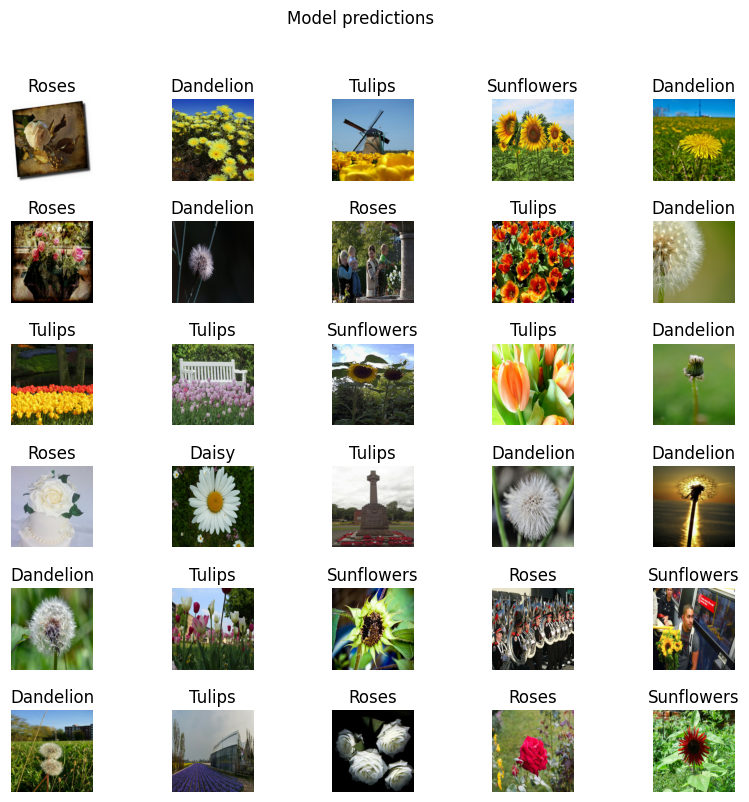

In [29]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

## Export and reload your model

Now that you've trained the model, export it as a SavedModel for reusing it later.

In [30]:
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path)

export_path

INFO:tensorflow:Assets written to: /tmp/saved_models/1698387070/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1698387070/assets


'/tmp/saved_models/1698387070'

Confirm that you can reload the SavedModel and that the model is able to output the same results:

In [31]:
reloaded = tf.keras.models.load_model(export_path)

In [32]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 493ms/step


In [33]:
abs(reloaded_result_batch - result_batch).max()

0.0

In [34]:
reloaded_predicted_id = tf.math.argmax(reloaded_result_batch, axis=-1)
reloaded_predicted_label_batch = class_names[reloaded_predicted_id]
print(reloaded_predicted_label_batch)

['roses' 'dandelion' 'tulips' 'sunflowers' 'dandelion' 'roses' 'dandelion'
 'roses' 'tulips' 'dandelion' 'tulips' 'tulips' 'sunflowers' 'tulips'
 'dandelion' 'roses' 'daisy' 'tulips' 'dandelion' 'dandelion' 'dandelion'
 'tulips' 'sunflowers' 'roses' 'sunflowers' 'dandelion' 'tulips' 'roses'
 'roses' 'sunflowers' 'tulips' 'sunflowers']


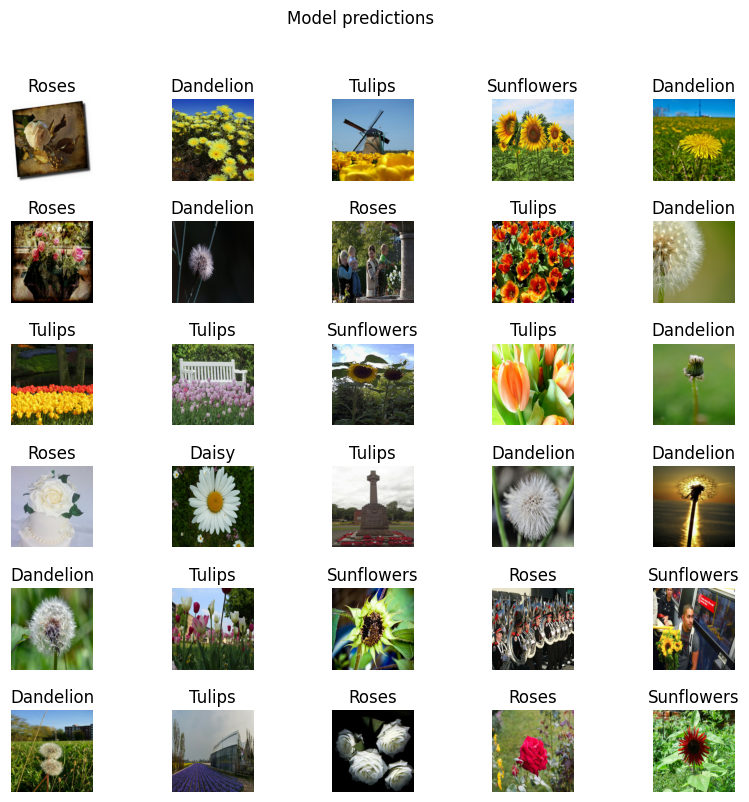

In [35]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(reloaded_predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

## Next steps

You can use the SavedModel to load for inference or convert it to a [TensorFlow Lite](https://www.tensorflow.org/lite/models/convert/)  model (for on-device machine learning) or a [TensorFlow.js](https://www.tensorflow.org/js/tutorials#convert_pretrained_models_to_tensorflowjs) model (for machine learning in JavaScript).

Discover [more tutorials](https://www.tensorflow.org/hub/tutorials) to learn how to use pre-trained models from TensorFlow Hub on image, text, audio, and video tasks.